In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "mmpot"))

import seaborn as sns
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.io import loadmat
import time

Numerical experiment trên CIFAR10, đặt hypothesis, thí nghiệm, và ghi lại kết quả trên Overleaf
- **Xử Lý Trước Hình Ảnh**:
    - **Original Image**: Bắt đầu với các hình ảnh CIFAR-10, mỗi ảnh có kích thước $32 \times 32 \times 3$ (định dạng RGB).
    - **Grayscale Conversion**: Chuyển đổi các hình ảnh từ RGB sang ảnh grayscale.
    - **Downscaling**: Giảm kích thước của hình ảnh từ $32 \times 32$ xuống $10 \times 10$.
    - **Histogram Generation**: Làm phẳng ảnh grayscale đã giảm kích thước $10 \times 10$ thành một histogram với 100 bins.

- **Điều Chỉnh Histogram**:
    - **Zero-Avoidance**: Thêm một giá trị nhỏ $10^{-6}$ vào mỗi bin trong histogram để tránh các giá trị bằng 0.
    - **Normalization**:
        - Đối với mỗi cặp histogram (marginals), chia từng bin cho tổng khối lượng lớn nhất giữa hai histogram.
        - Điều này dẫn đến một marginal có tổng khối lượng bằng 1, trong khi marginal còn lại có thể có tổng khối lượng nhỏ hơn 1.

- **Tính Toán Ma Trận Cost**:
    - **Squared Euclidean Distance**: Sử dụng khoảng cách Euclidean bình phương giữa các vị trí pixel làm metric chi phí $C$ cho việc vận chuyển.
    - **Normalization**: Chuẩn hóa ma trận chi phí sao cho $\|\mathbf{C}\|_{\text{max}} = 1$.

- **Thiết Lập Bài Toán Vận Chuyển**:
    - **Transport Mass**: Đặt tổng khối lượng vận chuyển bằng 0.8 lần tổng khối lượng nhỏ nhất giữa hai marginals.

In [2]:
def measure_sparsity(solution_matrix, threshold=1e-10):
    """
    Hàm này đo lường sparsity của một ma trận, xem xét các phần tử có giá trị tuyệt đối
    nhỏ hơn ngưỡng đã chỉ định là bằng 0.

    Sparsity được định nghĩa là tỷ lệ các phần tử được xem là bằng 0 trong ma trận.

    Tham số:
    solution_matrix (np.ndarray): Ma trận cần đo lường sparsity.
    threshold (float): Ngưỡng dưới đó các phần tử được coi là bằng 0 (mặc định là 1e-10).

    Trả về:
    float: Độ sparsity của ma trận, dưới dạng giá trị từ 0 đến 1.
    """
    # Đếm số lượng phần tử được coi là bằng 0 (nhỏ hơn ngưỡng)
    zero_elements = np.sum(np.abs(solution_matrix) < threshold)

    # Tính tổng số phần tử trong ma trận
    total_elements = solution_matrix.size

    # Tính độ sparsity dưới dạng tỷ lệ của các phần tử được coi là bằng 0
    sparsity = zero_elements / total_elements

    return sparsity

In [3]:
# Hàm giải bài toán Optimal Transport (OT) không có regularizer
def solve_ot(source_hist, target_hist, C):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) == source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) == target_hist,  # Tổng theo cột bằng phân phối đích
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value, prob.value


# Hàm giải POT với quadratic regularizer
def solve_pot_quadratic_regularization(source_hist, target_hist, C, s, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán POT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,
        cp.sum(X, axis=0) <= target_hist,
        cp.sum(X) == s,
    ]

    # Định nghĩa hàm mục tiêu với regularization quadratic
    objective = cp.Minimize(cp.trace(C.T @ X) + (epsilon / 2) * cp.norm(X, "fro") ** 2)

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value, prob.value

### a) Helper function

### b) Numerical experiments on CIFAR10

#### Load data

In [4]:
import cv2
from sklearn.datasets import fetch_openml

B = 10

# Load CIFAR-10 dataset using sklearn
cifar10 = fetch_openml('CIFAR_10', version=1)
# Access the data and target
X = cifar10.data
y = cifar10.target

# Reshape and normalize the data
X = X.reshape(-1, 3, 32, 32).astype('float32')
print('Dm Phi')

# Since X is in (n_samples, channels, height, width) format, you may want to convert it to (n_samples, height, width, channels) for proper visualization
X = np.transpose(X, (0, 2, 3, 1)) / 255.0  # Normalize the pixel values to [0, 1]

# Original Images: Take the first and second images from CIFAR-10
original_image_1 = X[204]
original_image_2 = X[1]

downscaled_image_1 = cv2.resize(original_image_1, (B, B), interpolation=cv2.INTER_AREA)
downscaled_image_2 = cv2.resize(original_image_2, (B, B), interpolation=cv2.INTER_AREA)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 16))
ax1.imshow(original_image_1)
ax1.set_title('Image 1')
ax2.imshow(original_image_2)
ax2.set_title("Image 2")

h:\Materials\AI Courses\.venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


#### Turn data into source and target distributions

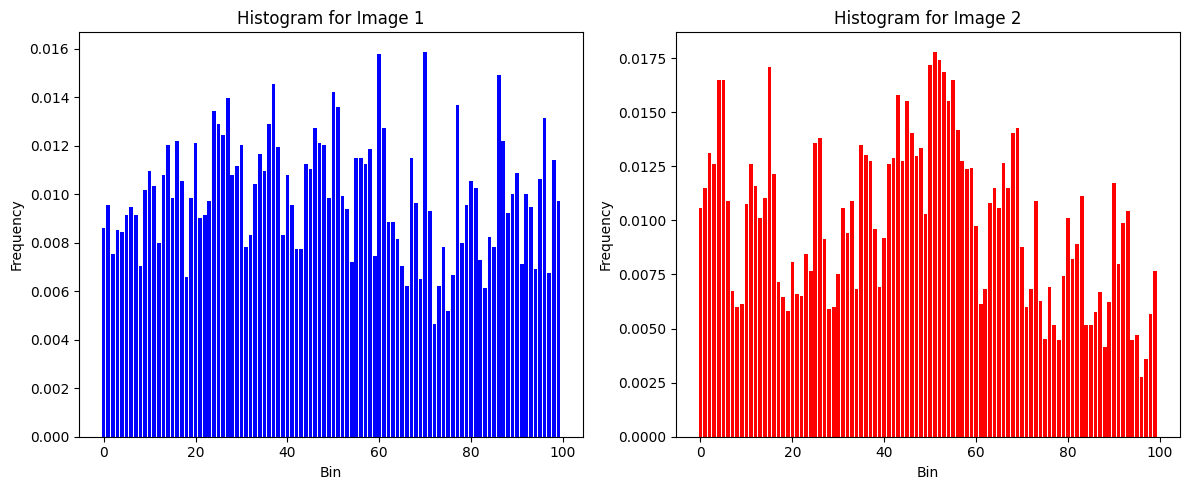

In [ ]:
# Grayscale Conversion: Convert both images to grayscale
gray_image_1 = cv2.cvtColor(downscaled_image_1, cv2.COLOR_RGB2GRAY)
gray_image_2 = cv2.cvtColor(downscaled_image_2, cv2.COLOR_RGB2GRAY)

# Histogram Generation: Flatten the 10x10 grayscale images into histograms with 100 bins
hist_1 = gray_image_1.flatten()
hist_2 = gray_image_2.flatten()

# Convert histograms to float type to avoid type casting errors
hist_1 = hist_1.astype(float)
hist_2 = hist_2.astype(float)

# Zero-Avoidance: Add a small value to each bin in both histograms to prevent zero entries
hist_1 += 1e-6
hist_2 += 1e-6

# Normalization: Normalize both histograms
max_mass = max(hist_1.sum(), hist_2.sum())
hist_1 = hist_1 / hist_1.sum()
hist_2 = hist_2 / hist_2.sum()
# Plot histogram for hist_1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(hist_1)), hist_1, color="blue")
plt.title("Histogram for Image 1")
plt.xlabel("Bin")
plt.ylabel("Frequency")

# Plot histogram for hist_2
plt.subplot(1, 2, 2)
plt.bar(range(len(hist_2)), hist_2, color="red")
plt.title("Histogram for Image 2")
plt.xlabel("Bin")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Define cost matrix

array([[  0.,   1.,   4., ..., 130., 145., 162.],
       [  1.,   0.,   1., ..., 117., 130., 145.],
       [  4.,   1.,   0., ..., 106., 117., 130.],
       ...,
       [130., 117., 106., ...,   0.,   1.,   4.],
       [145., 130., 117., ...,   1.,   0.,   1.],
       [162., 145., 130., ...,   4.,   1.,   0.]])

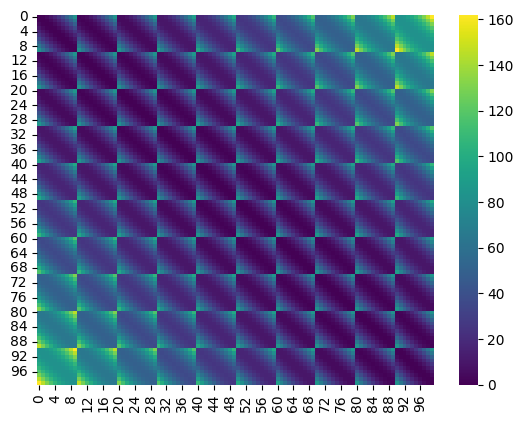

In [ ]:
C = np.zeros((B * B, B * B), dtype=float)

# Calculate the squared Euclidean distance for the cost matrix
for i in range(B):
    for j in range(B):
        for k in range(B):
            for l in range(B):
                row = i * B + j
                col = k * B + l
                C[row, col] = (i - k) ** 2 + (j - l) ** 2

# Normalize the cost matrix
C = C
sns.heatmap(C, cmap="viridis")
C


#### Numerical experiments on CIFAR10 with OT

0.06981015205383301


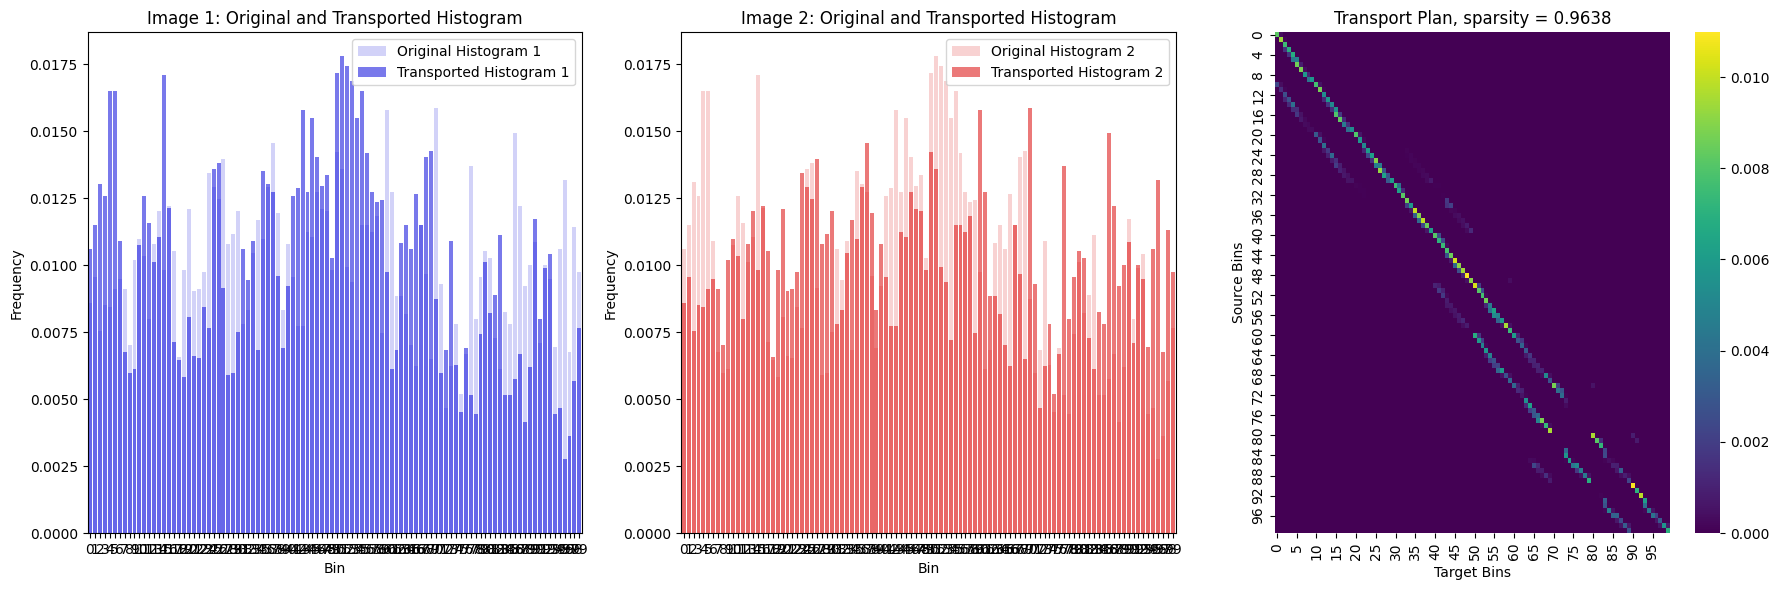

In [ ]:
start_time = time.time()
T_ot, W_ot = solve_ot(hist_1, hist_2, C)
# Apply the transport matrix to the source image
runtime = time.time() - start_time
print(runtime)

# Calculate the transported histograms
if T_ot is not None:
    transported_hist_1 = T_pot.sum(0)
    transported_hist_2 = T_pot.sum(1)

    # Set up the figure and axes
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original and transported histogram for Image 1
    sns.barplot(
        x=np.arange(100),
        y=hist_1,
        color="blue",
        alpha=0.2,
        ax=ax[0],
        label="Original Histogram 1",
    )
    sns.barplot(
        x=np.arange(100),
        y=transported_hist_1,
        color="blue",
        alpha=0.6,
        ax=ax[0],
        label="Transported Histogram 1",
    )
    ax[0].set_title("Image 1: Original and Transported Histogram")
    ax[0].set_xlabel("Bin")
    ax[0].set_ylabel("Frequency")
    ax[0].legend()

    # Plot original and transported histogram for Image 2
    sns.barplot(
        x=np.arange(100),
        y=hist_2,
        color="red",
        alpha=0.2,
        ax=ax[1],
        label="Original Histogram 2",
    )
    sns.barplot(
        x=np.arange(100),
        y=transported_hist_2,
        color="red",
        alpha=0.6,
        ax=ax[1],
        label="Transported Histogram 2",
    )
    ax[1].set_title("Image 2: Original and Transported Histogram")
    ax[1].set_xlabel("Bin")
    ax[1].set_ylabel("Frequency")
    ax[1].legend()

    # Plot the transport plan
    sns.heatmap(T_ot, ax=ax[2], cmap="viridis")
    ax[2].set_title("Transport Plan, sparsity = " + str(measure_sparsity(T_ot)))
    ax[2].set_xlabel("Target Bins")
    ax[2].set_ylabel("Source Bins")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

#### Numerical experiments on CIFAR10 with POT on multiple epsilon

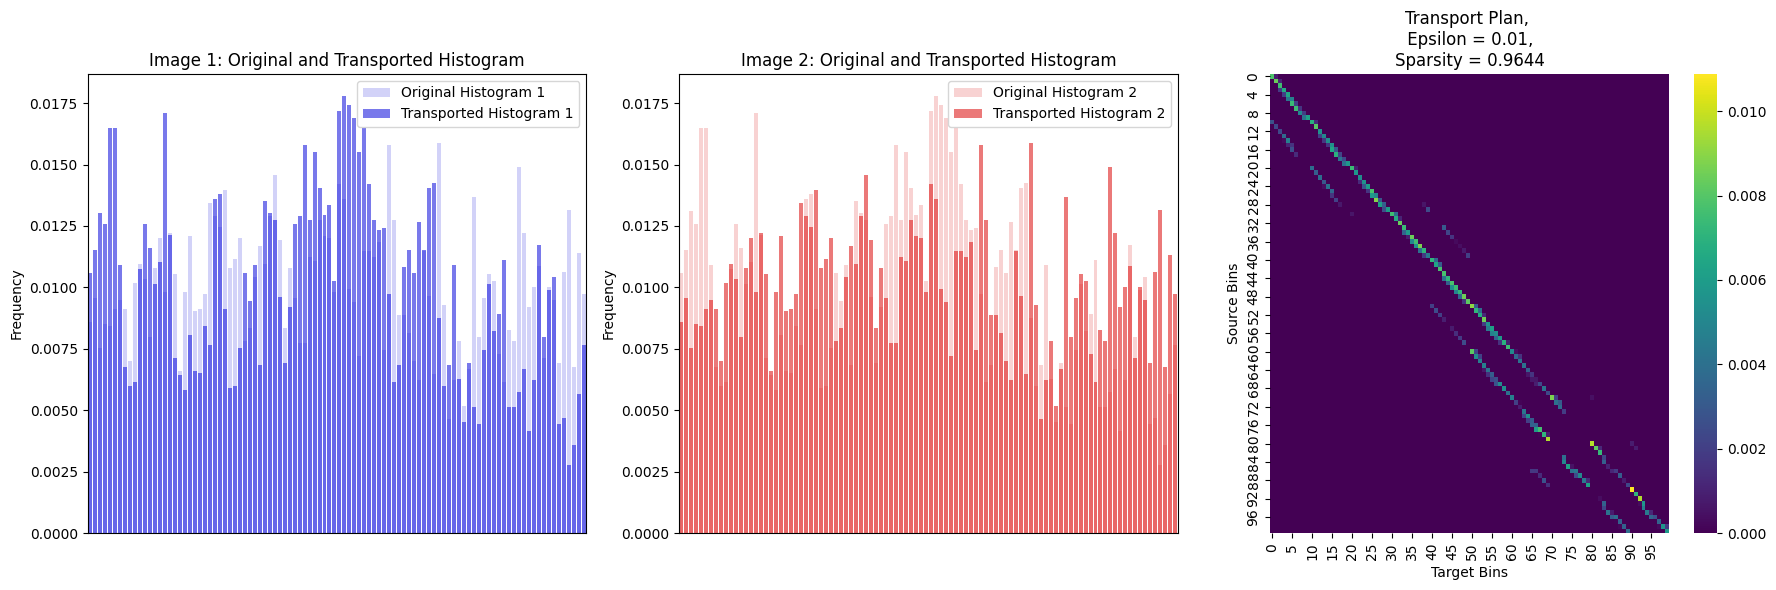

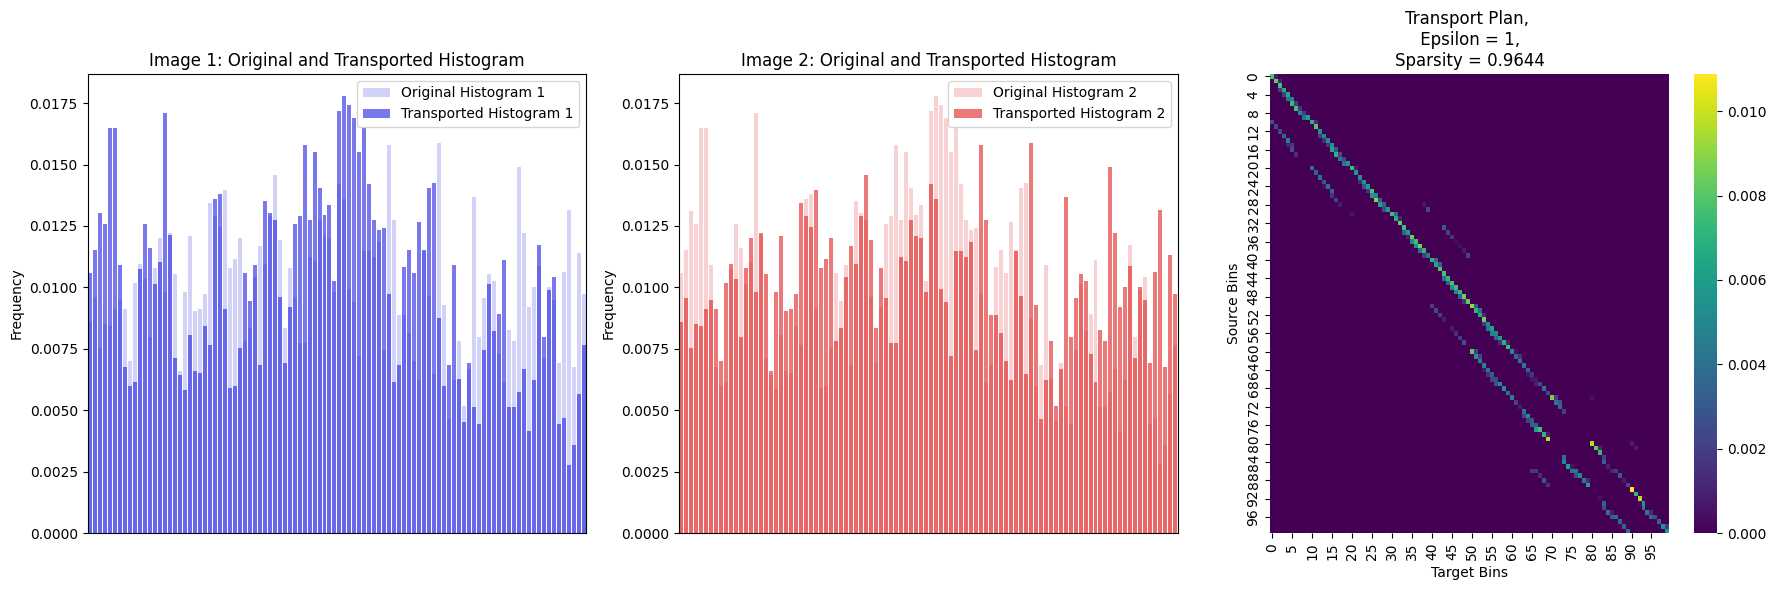

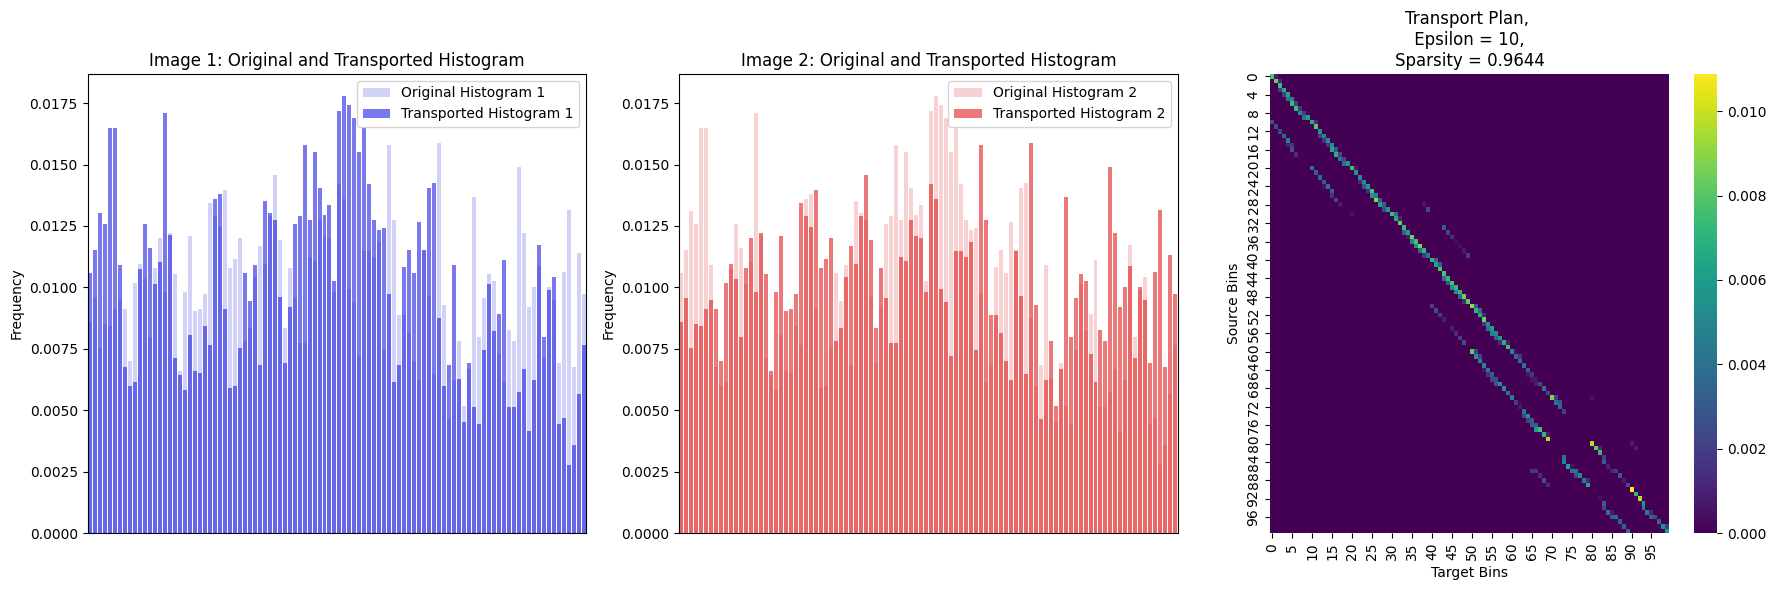

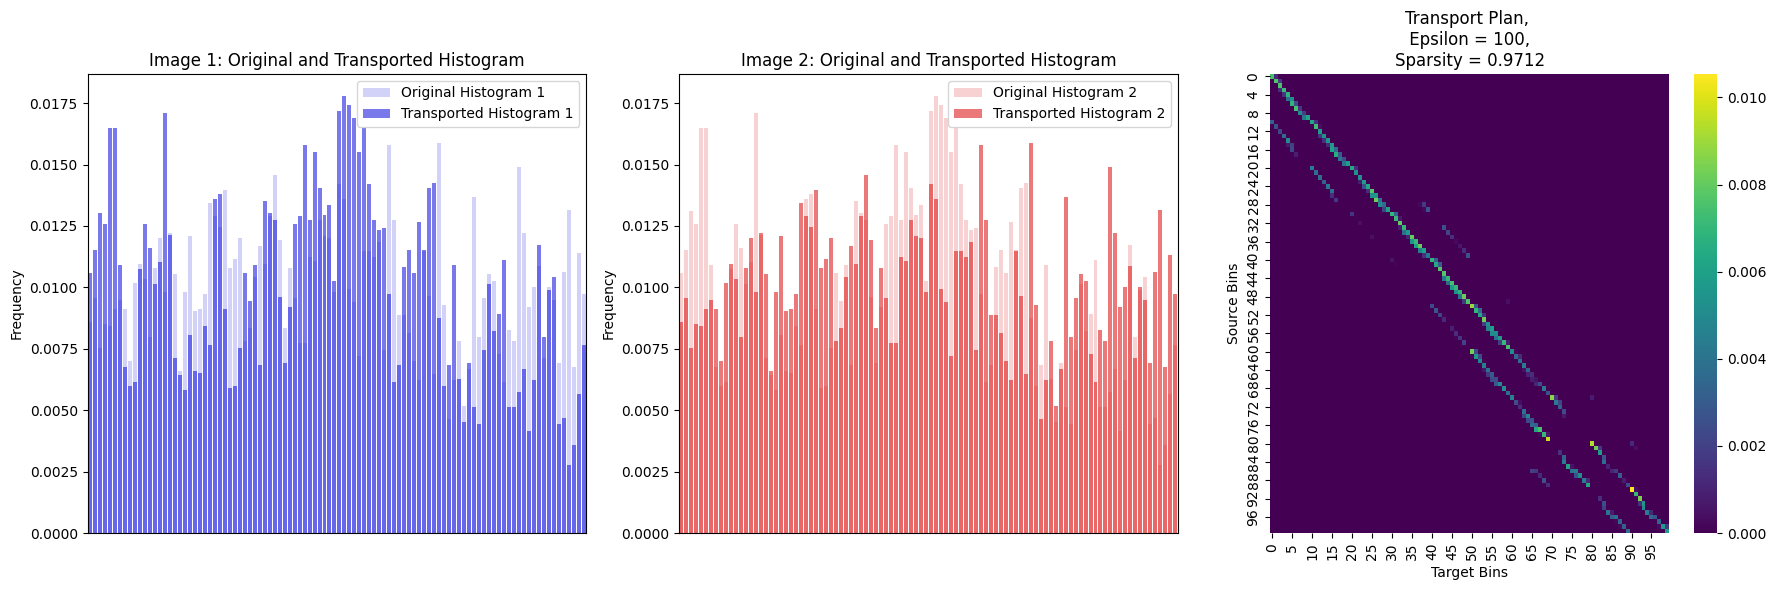

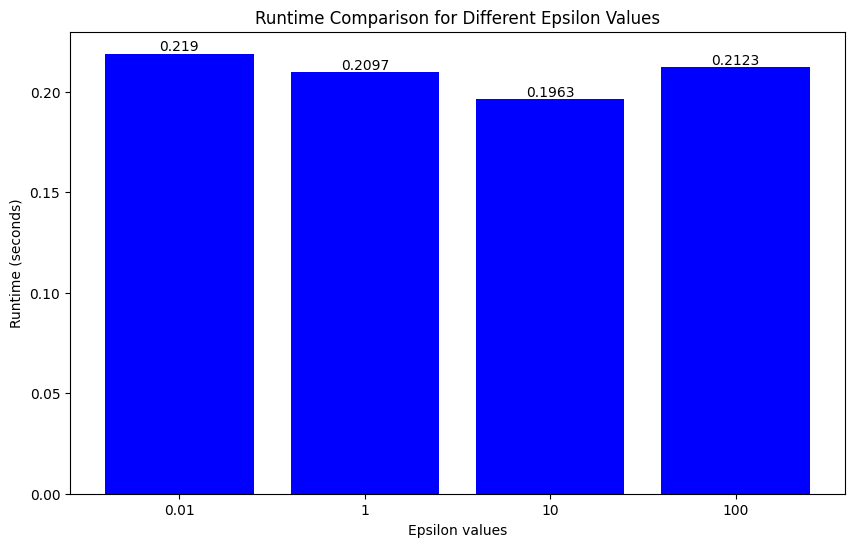

In [ ]:
# Transport Mass: Set the total transported mass to 0.8 times the minimum total mass between the two marginals
lambda_param = 0.9999
s = lambda_param * min(np.sum(hist_1), np.sum(hist_2))

# Define the regularization parameter epsilon
epsilons = [0.01, 1, 10, 100]  # This value can be adjusted depending on the problem requirements
runtimes = []

for epsilon in epsilons:
    start_time = time.time()
    T_pot, W_pot = solve_pot_quadratic_regularization(hist_1, hist_2, C, s, epsilon)
    # Apply the transport matrix to the source image
    runtime = time.time() - start_time
    runtimes.append(runtime)

    # Calculate the transported histograms
    transported_hist_1 = T_pot.sum(0)
    transported_hist_2 = T_pot.sum(1)

    # Set up the figure and axes
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original and transported histogram for Image 1
    sns.barplot(
        x=np.arange(len(hist_1)),
        y=hist_1,
        color="blue",
        alpha=0.2,
        ax=ax[0],
        label="Original Histogram 1",
    )
    sns.barplot(
        x=np.arange(len(transported_hist_1)),
        y=transported_hist_1,
        color="blue",
        alpha=0.6,
        ax=ax[0],
        label="Transported Histogram 1",
    )
    ax[0].set_title("Image 1: Original and Transported Histogram")
    ax[0].set_xlabel("")  # Remove x-axis label
    ax[0].set_ylabel("Frequency")
    ax[0].legend()
    ax[0].tick_params(
        axis="x", which="both", bottom=False, top=False, labelbottom=False
    )  # Remove x-axis ticks and labels

    # Plot original and transported histogram for Image 2
    sns.barplot(
        x=np.arange(len(hist_2)),
        y=hist_2,
        color="red",
        alpha=0.2,
        ax=ax[1],
        label="Original Histogram 2",
    )
    sns.barplot(
        x=np.arange(len(transported_hist_2)),
        y=transported_hist_2,
        color="red",
        alpha=0.6,
        ax=ax[1],
        label="Transported Histogram 2",
    )
    ax[1].set_title("Image 2: Original and Transported Histogram")
    ax[1].set_xlabel("")  # Remove x-axis label
    ax[1].set_ylabel("Frequency")
    ax[1].legend()
    ax[1].tick_params(
        axis="x", which="both", bottom=False, top=False, labelbottom=False
    )  # Remove x-axis ticks and labels

    # Plot the transport plan
    sns.heatmap(T_pot, ax=ax[2], cmap="viridis")
    ax[2].set_title("Transport Plan, \n Epsilon = " + str(epsilon) + ", \nSparsity = " + str(measure_sparsity(T_pot)))
    ax[2].set_xlabel("Target Bins")
    ax[2].set_ylabel("Source Bins")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Visualize runtime comparison
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([str(eps) for eps in epsilons], runtimes, color="blue")
ax.set_xlabel("Epsilon values")
ax.set_ylabel("Runtime (seconds)")
ax.set_title("Runtime Comparison for Different Epsilon Values")

# Annotate bars with runtime values
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 4),
        ha="center",
        va="bottom",
    )

plt.show()